In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np

In [2]:
def get_fold_results(fold):
    f = open(f"../competitive_data/results/final_results_{fold}.json")
    fold_results = json.load(f)
    f.close()
    combinations = list(fold_results["train"].keys())
    combinations.pop(combinations.index("predictions"))
    combinations.pop(combinations.index("prediction_times"))
    times = []
    for dataset in fold_results:
        dataset_times = {}
        dataset_times["dataset"] = dataset
        for combination in combinations:
            dataset_times[combination] = fold_results[dataset][combination]
        times.append(dataset_times)
    times = pd.DataFrame(times)
    times.to_latex(f"../competitive_data/latex/fold_{fold}_times.txt")
    for dataset in fold_results:
        dataset_times = {}
        for combination in combinations:
            dataset_times[combination] = fold_results[dataset][combination]
        plt.figure(figsize=(8, 6))
        bars = plt.bar(list(dataset_times.keys()), list(dataset_times.values()))
        plt.axhline(y=dataset_times["chuffed_02_compact.eprime"], color='red', linestyle='--')
        plt.yscale("log")
        bars[list(dataset_times.keys()).index("chuffed_02_compact.eprime")].set_color("red")
        plt.xticks(rotation=90)
        plt.title(f'Times for each combination in the {dataset} set (fold {fold})')
        plt.savefig(f'../competitive_data/imgs/comb_time_{dataset}_fold_{fold}.svg', format='svg')
        plt.show()
    prediction_times = {}
    for key in fold_results:
        prediction_times[key] = fold_results[key]["prediction_times"]
    pred_times = []
    for dataset in prediction_times:
        for time in prediction_times[dataset]:
            pred_times.append(time["prediction_time"])
    plt.boxplot(pred_times)
    plt.title(f"prediction time of an instance")
    plt.savefig(f'../competitive_data/imgs/prediction_time.svg', format='svg')
    plt.show()


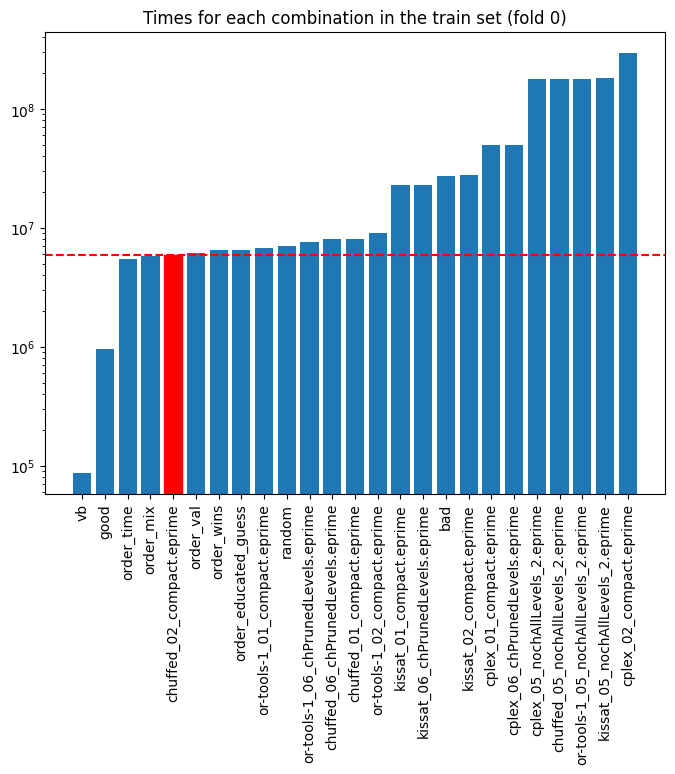

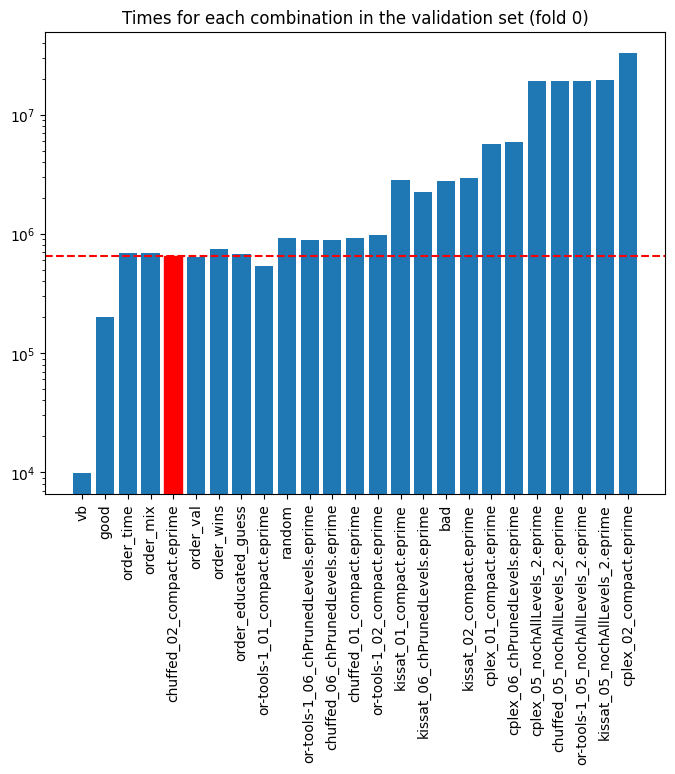

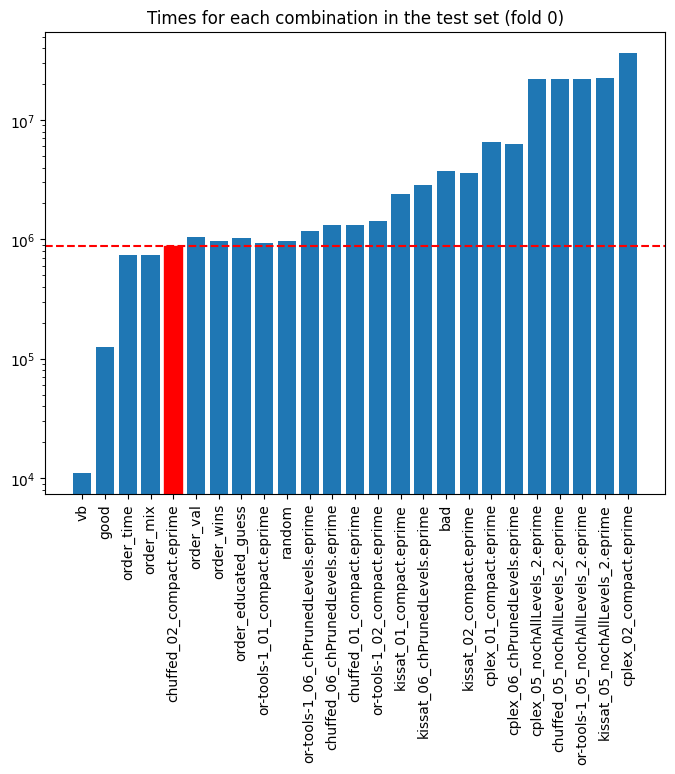

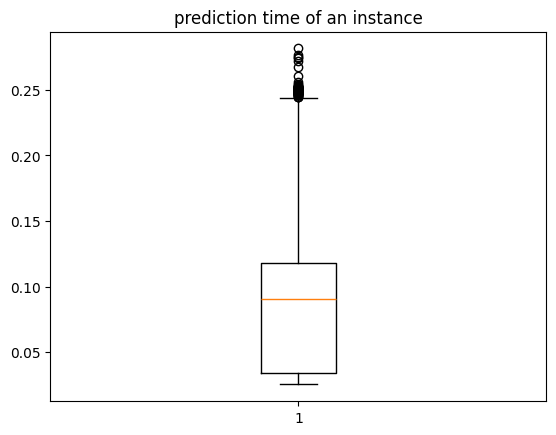

In [3]:
get_fold_results(0)

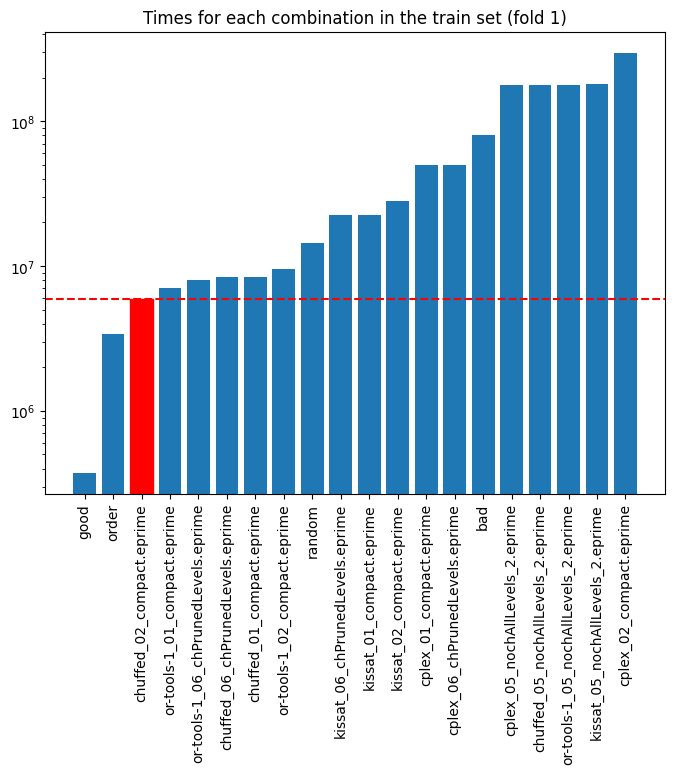

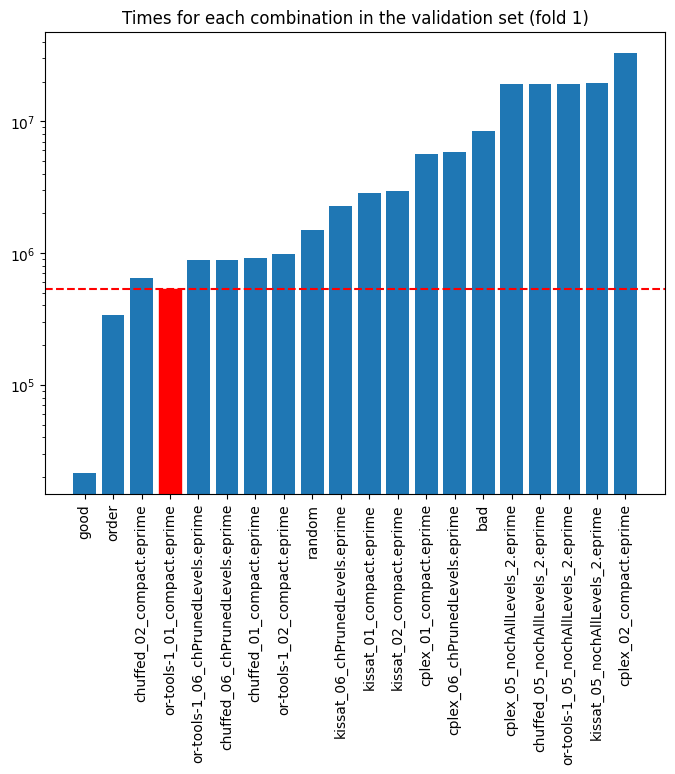

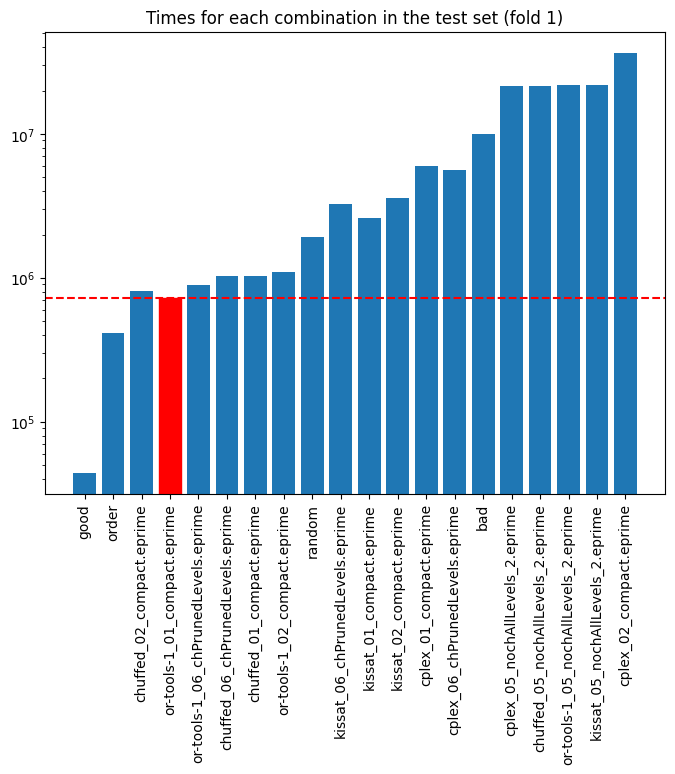

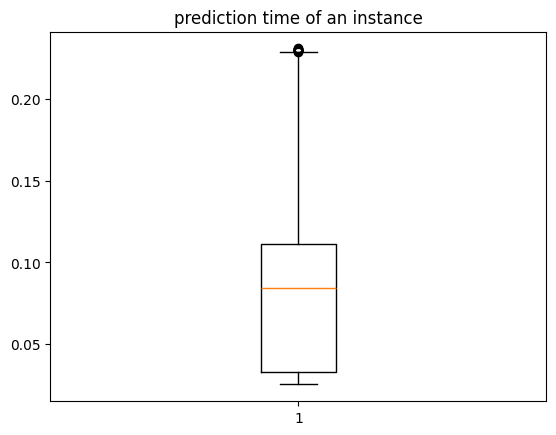

In [21]:
get_fold_results(1)

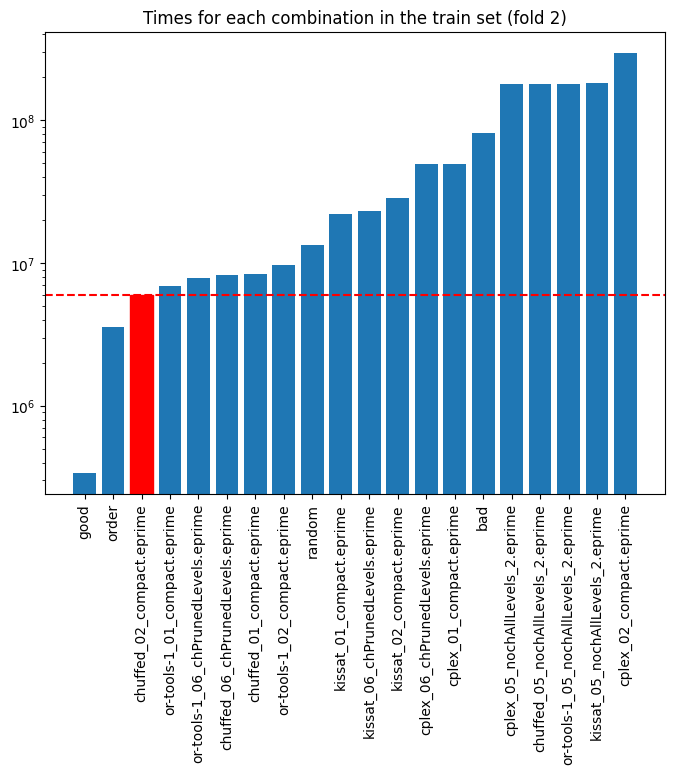

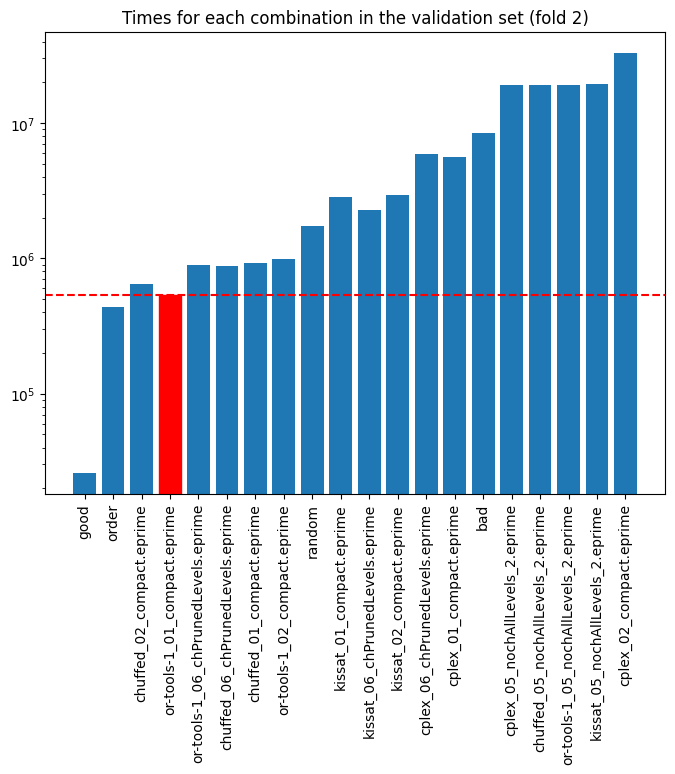

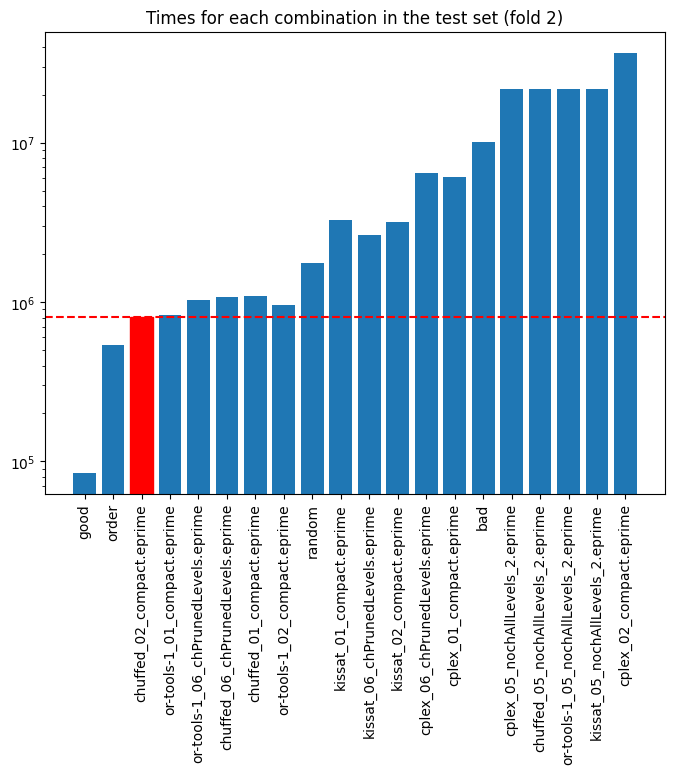

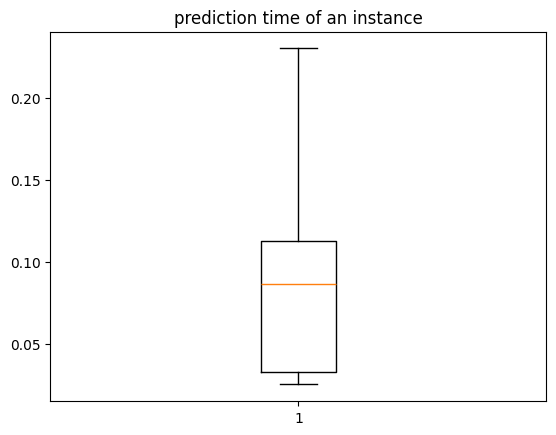

In [8]:
get_fold_results(2)

In [23]:
def load_history(fold):
    base = "../competitive_data/history/"
    files = [os.path.join(base, file) for file in os.listdir(base) if f"fold_{fold}" in file]
    train_history = {}
    for file in files:
        time = file.split("_")[-1].replace(".json", "")
        f = open(file)
        train_history[time] = json.load(f)
        f.close()
    sorted_keys = sorted(train_history.keys(), key=lambda x: int(x[1:]))

    train_history = {key: train_history[key] for key in sorted_keys}
    colors = ['blue', 'red']
    loss_history = {}
    accuracy_history = {}
    f1_history = {}
    precision_history = {}
    recall_history = {}
    for time_stamp in train_history:
        for dataset in train_history[time_stamp]:
            if not dataset in loss_history:
                loss_history[dataset] = []
                accuracy_history[dataset] = []
                f1_history[dataset] = []
                precision_history[dataset] = []
                recall_history[dataset] = []
            loss_history[dataset] += train_history[time_stamp][dataset]["loss"]
            accuracy_history[dataset] += train_history[time_stamp][dataset]["accuracy"]
            f1_history[dataset] += train_history[time_stamp][dataset]["f1_score"]
            precision_history[dataset] += train_history[time_stamp][dataset]["precision"]
            recall_history[dataset] += train_history[time_stamp][dataset]["recall"]
    for i, (key, values) in enumerate(loss_history.items()):
        plt.plot([i + 1 for i in range(len(values))], values, color=colors[i % len(colors)], label=key) 
    plt.axvline(3, color="green")
    plt.text(2.8, min(values), f'change of lr', rotation=90, va='bottom', ha='center', fontsize=12, color='green')
    plt.axvline(6, color="green")
    plt.text(5.8, min(values), f'change of loss', rotation=90, va='bottom', ha='center', fontsize=12, color='green')
    plt.legend()
    plt.title(f"loss history (fold {fold})")
    plt.savefig(f'../competitive_data/imgs/loss_history_{dataset}_fold_{fold}.svg', format='svg')
    plt.show()
    
    for i, (key, values) in enumerate(accuracy_history.items()):
        plt.plot([i + 1 for i in range(len(values))], values, color=colors[i % len(colors)], label=key) 
    plt.axvline(3, color="green")
    plt.text(2.8, min(values), f'change of lr', rotation=90, va='bottom', ha='center', fontsize=12, color='green')
    plt.axvline(6, color="green")
    plt.text(5.8, min(values), f'change of loss', rotation=90, va='bottom', ha='center', fontsize=12, color='green')
    plt.legend()
    plt.title(f"accuracy history (fold {fold})")
    plt.savefig(f'../competitive_data/imgs/accuracy_history_{dataset}_fold_{fold}.svg', format='svg')
    plt.show()

    for i, (key, values) in enumerate(f1_history.items()):
        plt.plot([i + 1 for i in range(len(values))], values, color=colors[i % len(colors)], label=key) 
    plt.axvline(3, color="green")
    plt.text(2.8, min(values), f'change of lr', rotation=90, va='bottom', ha='center', fontsize=12, color='green')
    plt.axvline(6, color="green")
    plt.text(5.8, min(values), f'change of loss', rotation=90, va='bottom', ha='center', fontsize=12, color='green')
    plt.legend()
    plt.title(f"f1 history (fold {fold})")
    plt.savefig(f'../competitive_data/imgs/f1_history_{dataset}_fold_{fold}.svg', format='svg')
    plt.show()

    for i, (key, values) in enumerate(precision_history.items()):
        plt.plot([i + 1 for i in range(len(values))], values, color=colors[i % len(colors)], label=key) 
    plt.axvline(3, color="green")
    plt.text(2.8, min(values), f'change of lr', rotation=90, va='bottom', ha='center', fontsize=12, color='green')
    plt.axvline(6, color="green")
    plt.text(5.8, min(values), f'change of loss', rotation=90, va='bottom', ha='center', fontsize=12, color='green')
    plt.legend()
    plt.title(f"precision history (fold {fold})")
    plt.savefig(f'../competitive_data/imgs/precision_history_{dataset}_fold_{fold}.svg', format='svg')
    plt.show()

    for i, (key, values) in enumerate(recall_history.items()):
        plt.plot([i + 1 for i in range(len(values))], values, color=colors[i % len(colors)], label=key) 
    plt.axvline(3, color="green")
    plt.text(2.8, min(values), f'change of lr', rotation=90, va='bottom', ha='center', fontsize=12, color='green')
    plt.axvline(6, color="green")
    plt.text(5.8, min(values), f'change of loss', rotation=90, va='bottom', ha='center', fontsize=12, color='green')
    plt.legend()
    plt.title(f"recall history (fold {fold})")
    plt.savefig(f'../competitive_data/imgs/recall_history_{dataset}_fold_{fold}.svg', format='svg')
    plt.show()

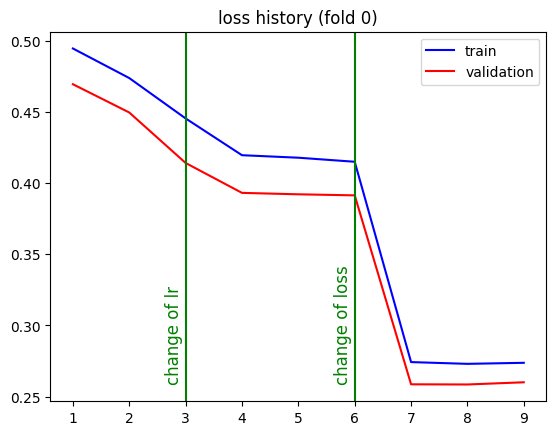

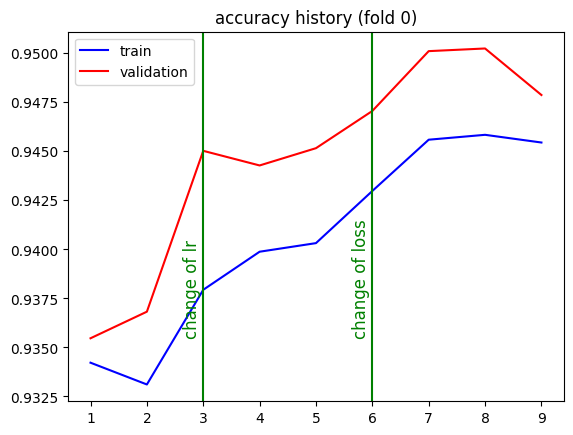

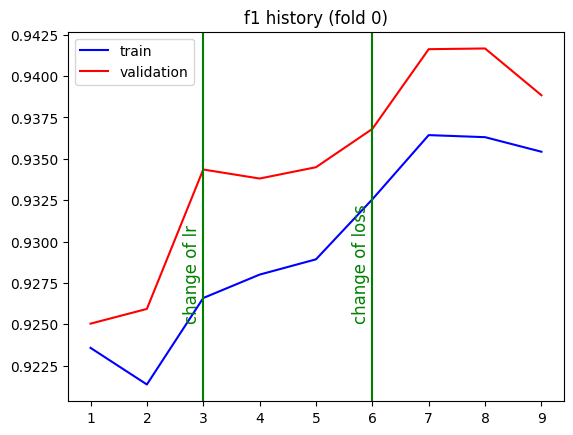

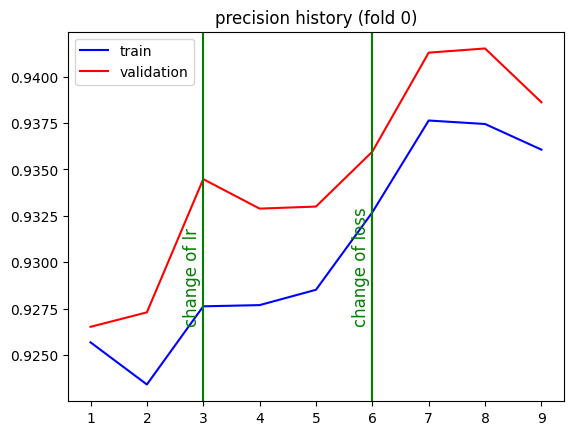

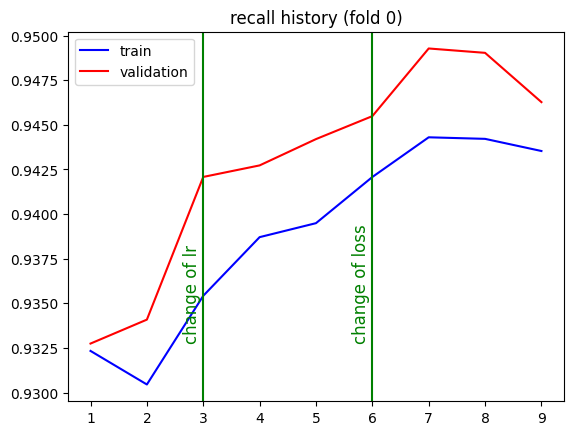

In [24]:
load_history(0)

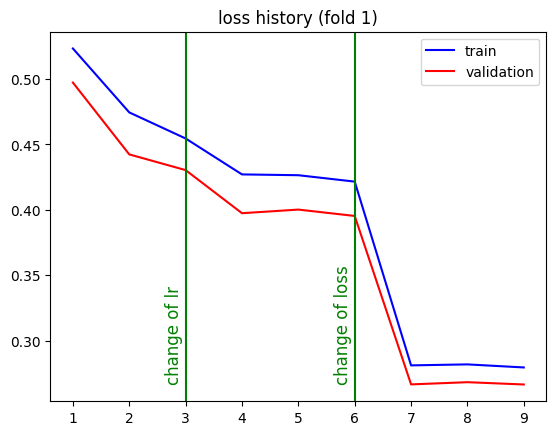

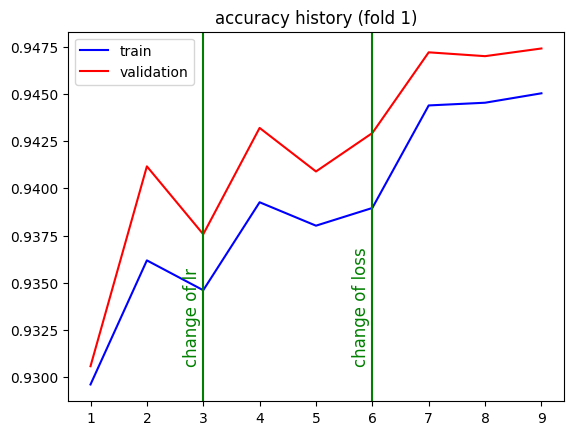

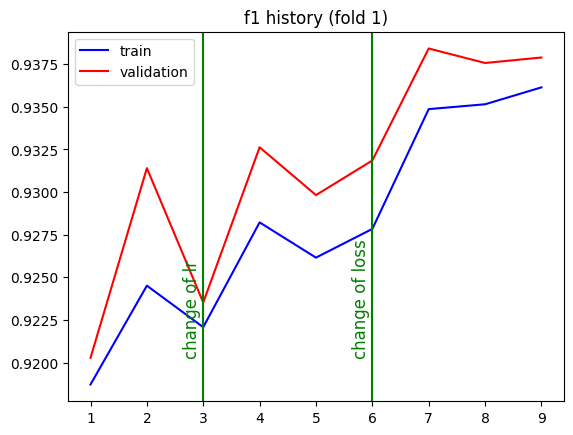

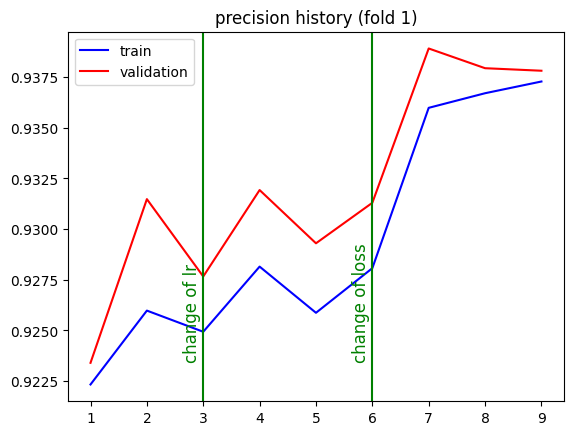

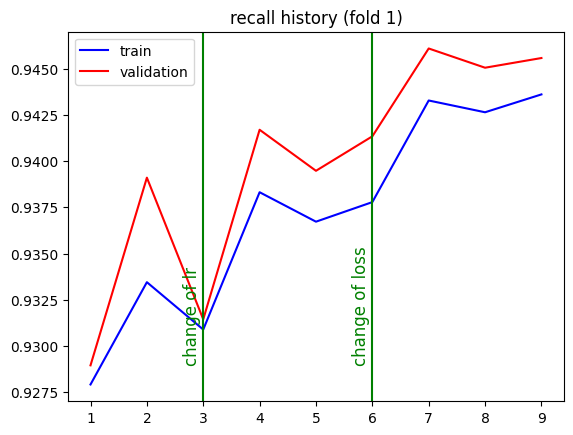

In [13]:
load_history(1)

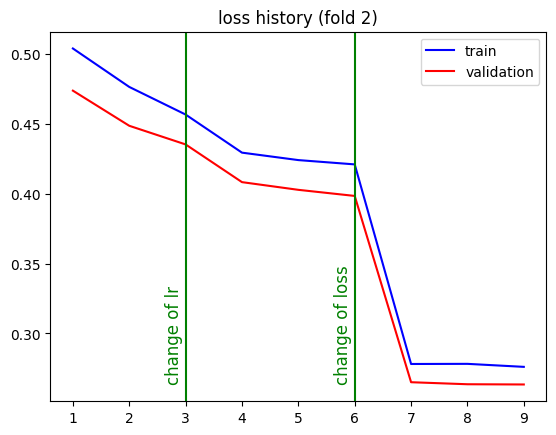

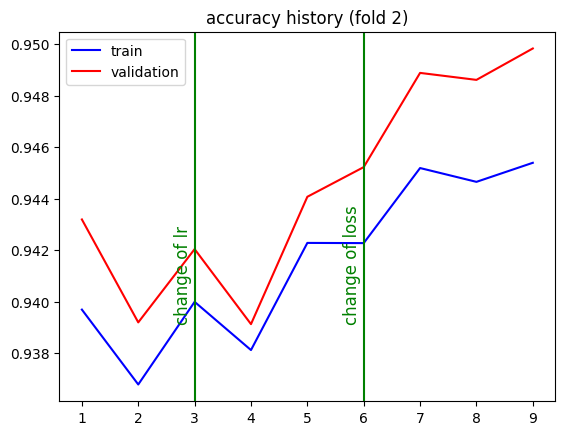

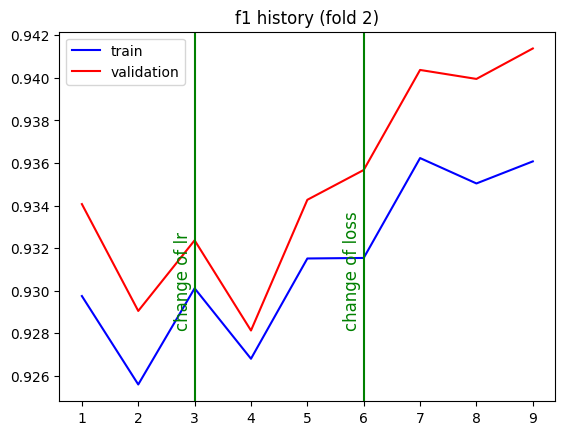

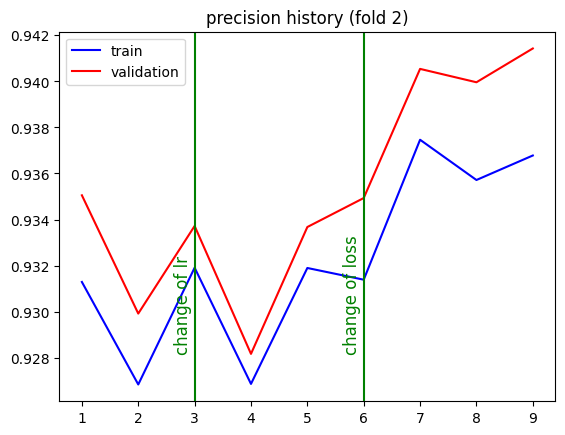

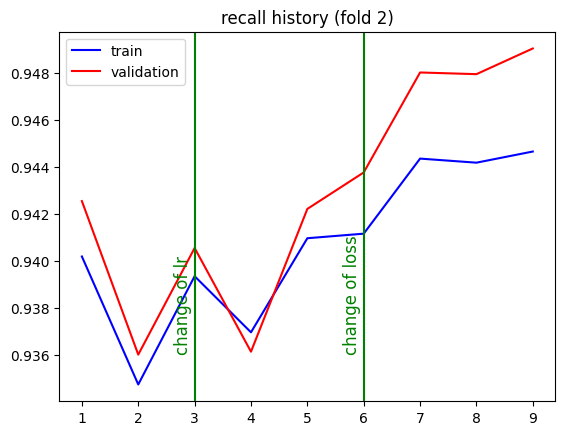

In [14]:
load_history(2)

In [2]:
f = open(f"../final_results_{2}.json")
fold_results = json.load(f)
f.close()

In [3]:
combinations = list(fold_results["train"].keys())

to_remove = []
for comb in combinations:
    if "eprime" not in comb:
        to_remove.append(comb)
for comb in to_remove:
    combinations.pop(combinations.index(comb))

In [4]:
choices = {"train": [(prediction["good"],prediction["order_time"], prediction["competitives"], prediction["true"], prediction["vb"], prediction["raw"]) for prediction in fold_results["train"]["predictions"]],
           "validation": [(prediction["good"],prediction["order_time"], prediction["competitives"], prediction["true"], prediction["vb"], prediction["raw"]) for prediction in fold_results["validation"]["predictions"]],
            "test": [(prediction["good"],prediction["order_time"], prediction["competitives"], prediction["true"], prediction["vb"], prediction["raw"]) for prediction in fold_results["test"]["predictions"]] }

In [5]:
fold_results["train"]["predictions"][0]

{'true': [1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
 'vb': 'cplex_06_chPrunedLevels.eprime',
 'good': 'cplex_06_chPrunedLevels.eprime',
 'competitives': ['chuffed_02_compact.eprime',
  'cplex_01_compact.eprime',
  'cplex_06_chPrunedLevels.eprime',
  'kissat_01_compact.eprime',
  'kissat_02_compact.eprime',
  'kissat_06_chPrunedLevels.eprime',
  'or-tools-1_01_compact.eprime',
  'or-tools-1_02_compact.eprime',
  'or-tools-1_06_chPrunedLevels.eprime'],
 'pred': [1.0,
  0.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0],
 'inst': 'EssenceCatalog/problems/csplib-prob001-CarSequencing/params/generated/c28b092a8f728601da45adef533a20e9.param',
 'times': {'kissat_06_chPrunedLevels.eprime': 5.68,
  'kissat_02_compact.eprime': 5.42,
  'kissat_01_compact.eprime': 6.73,
  'kissat_05_nochAllLevels_2.eprime': 69.57,
  'chuffed_06_chPrunedLevels.eprime': 43.85,
  'chuffed_02_compact.eprime': 4.33,
  'chuffed_01_compact.eprime': 41.64,
  'chuf

In [6]:
trues = [pred["true"] for pred in fold_results["train"]["predictions"]]
preds = [pred["pred"] for pred in fold_results["train"]["predictions"]]

In [7]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
metrics = []
for set in ["train", "validation", "test"]:
    trues_np = np.array([pred["true"] for pred in fold_results[set]["predictions"]])
    preds_np = np.array([pred["pred"] for pred in fold_results[set]["predictions"]])
    for i, comb in enumerate(combinations):

        set_metrics = {"set": set}
        set_metrics["combination"] = comb
        set_metrics["accuracy"] = accuracy_score(trues_np[:, i], preds_np[:, i])
        set_metrics["f1"] = f1_score(trues_np[:, i], preds_np[:, i])
        set_metrics["precision"] = precision_score(trues_np[:, i], preds_np[:, i])
        set_metrics["recall"] = recall_score(trues_np[:, i], preds_np[:, i])
        metrics.append(set_metrics)
dict_metrics = {comb: {"f1":[], "accuracy":[], "precision":[], "recall":[]} for comb in combinations}
for metric in metrics:
    dict_metrics[metric["combination"]]["accuracy"].append(metric["accuracy"])
    dict_metrics[metric["combination"]]["f1"].append(metric["f1"])
    dict_metrics[metric["combination"]]["precision"].append(metric["precision"])
    dict_metrics[metric["combination"]]["recall"].append(metric["recall"])
for key in dict_metrics:
    for metric in dict_metrics[key]:
        dict_metrics[key][metric] = np.average(dict_metrics[key][metric])
pd.DataFrame(dict_metrics)

,chuffed_02_compact.eprime,or-tools-1_01_compact.eprime,or-tools-1_06_chPrunedLevels.eprime,chuffed_06_chPrunedLevels.eprime,chuffed_01_compact.eprime,or-tools-1_02_compact.eprime,kissat_01_compact.eprime,kissat_06_chPrunedLevels.eprime,kissat_02_compact.eprime,cplex_06_chPrunedLevels.eprime,cplex_01_compact.eprime,cplex_05_nochAllLevels_2.eprime,chuffed_05_nochAllLevels_2.eprime,or-tools-1_05_nochAllLevels_2.eprime,kissat_05_nochAllLevels_2.eprime,cplex_02_compact.eprime
f1,0.908029,0.862428,0.995874,0.906934,0.943646,1.0,0.996744,0.936005,0.937069,0.969756,0.996567,0.937082,0.904309,0.989138,0.996621,0.899802
accuracy,0.914514,0.852053,0.991952,0.913884,0.981555,1.0,0.993655,0.978792,0.933959,0.965702,0.993299,0.934459,0.910586,0.987459,0.993409,0.907741
precision,0.891576,0.860309,0.996341,0.889222,0.961785,1.0,0.996427,0.969918,0.924479,0.979366,0.998175,0.927865,0.919826,0.983066,0.997133,0.934864
recall,0.925198,0.864701,0.995417,0.925407,0.926381,1.0,0.997071,0.904505,0.950014,0.960334,0.994967,0.946498,0.889418,0.995290,0.996115,0.867343


In [12]:
sort_dict_metrics = [k for k, _ in sorted(dict_metrics.items(), key= lambda x: x[1]["precision"], reverse=True)]

sort_dict_metrics

['or-tools-1_02_compact.eprime',
 'cplex_01_compact.eprime',
 'kissat_05_nochAllLevels_2.eprime',
 'kissat_01_compact.eprime',
 'or-tools-1_06_chPrunedLevels.eprime',
 'or-tools-1_05_nochAllLevels_2.eprime',
 'cplex_06_chPrunedLevels.eprime',
 'kissat_06_chPrunedLevels.eprime',
 'chuffed_01_compact.eprime',
 'cplex_02_compact.eprime',
 'cplex_05_nochAllLevels_2.eprime',
 'kissat_02_compact.eprime',
 'chuffed_05_nochAllLevels_2.eprime',
 'chuffed_02_compact.eprime',
 'chuffed_06_chPrunedLevels.eprime',
 'or-tools-1_01_compact.eprime']

In [18]:
idx2comb = {comb:i for comb, i in enumerate(combinations)}
stats = {comb: {"tp": 0, "tn": 0, "fp": 0, "fn":0} for comb in combinations}
for i in range(len(trues)):
    true = trues[i]
    pred = preds[i]
    for j in range(len(true)):
        if true[j] == pred[j]:
            if true[j] == 1:
                stats[idx2comb[j]]["tp"] += 1
            else:
                stats[idx2comb[j]]["tn"] += 1
        else:
            if true[j] == 1:
                stats[idx2comb[j]]["fn"] += 1
            else:
                stats[idx2comb[j]]["fp"] += 1

In [6]:
combinations = sorted(combinations)

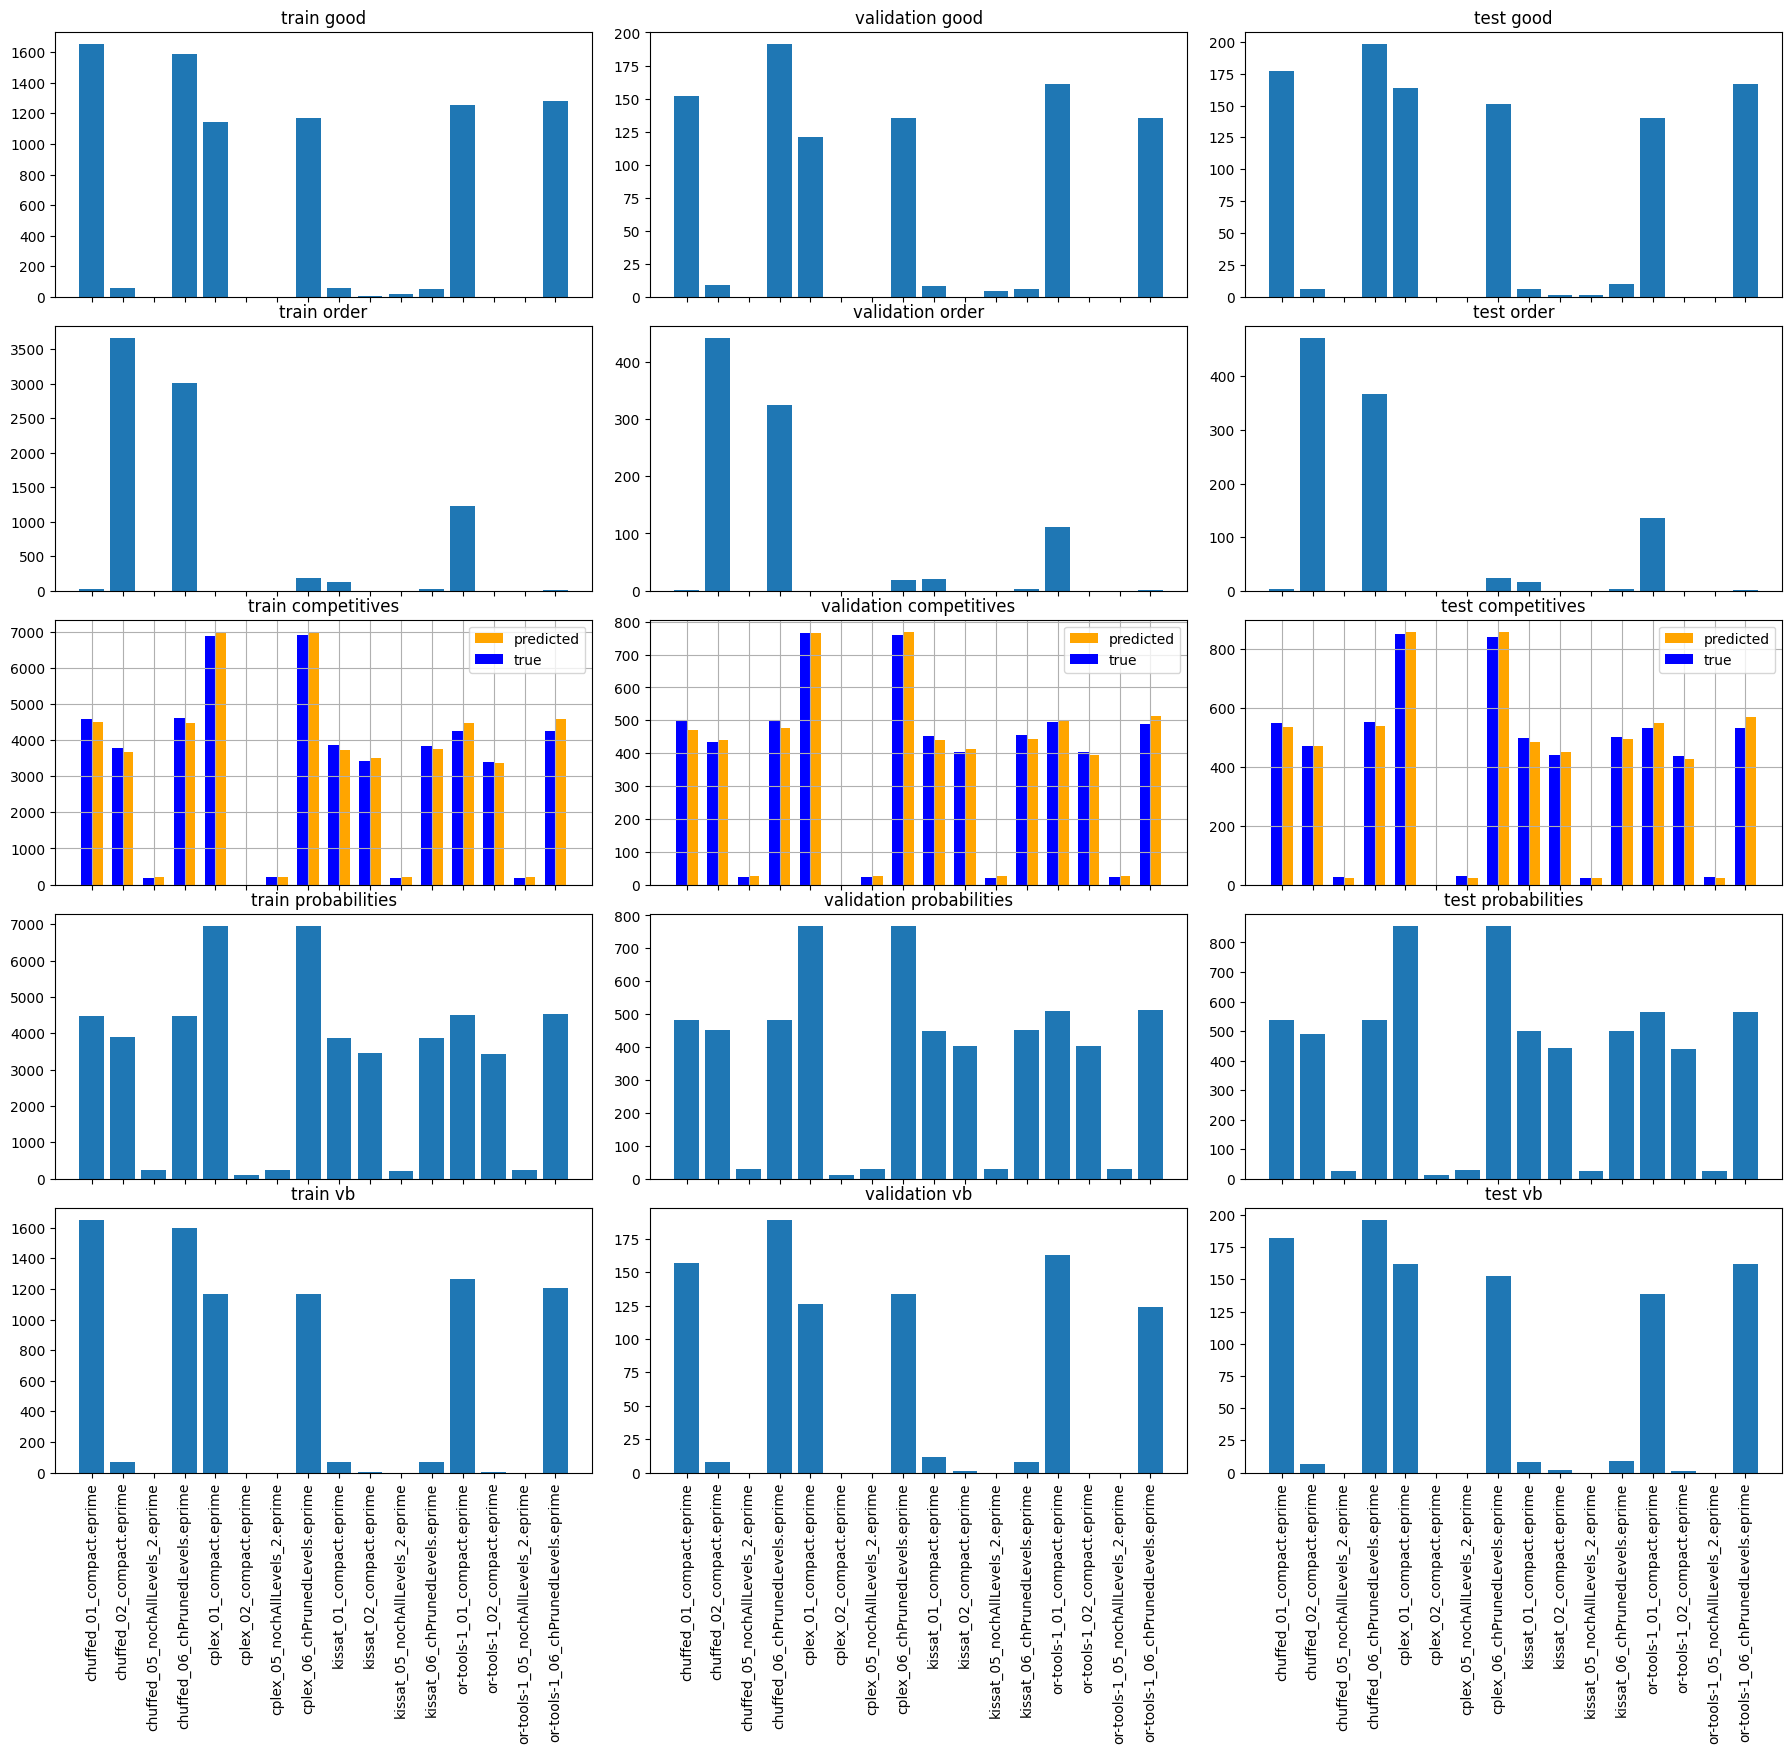

In [28]:
fig_bar, axs_bar = plt.subplots(5, 3, figsize=(18, 15), sharex=True)
fig_bar.tight_layout()
for i, set in enumerate(choices.keys()):
    good_choiches = {comb: 0 for comb in combinations}
    order_choiches = {comb: 0 for comb in combinations}
    all_choiches = {comb: 0 for comb in combinations}
    true_comp = {comb: 0 for comb in combinations}
    prob_comp = {comb: 0 for comb in combinations}
    vb = {comb: 0 for comb in combinations}
    for pred in choices[set]:
        good_choiches[pred[0]] += 1
        order_choiches[pred[1]] += 1
        for comb in pred[2]:
            all_choiches[comb] += 1
        for comb_idx, v in enumerate(pred[3]):
            if v == 0:
                true_comp[combinations[comb_idx]] += 1
        for comb_idx, v in enumerate(pred[5]):
            prob_comp[combinations[comb_idx]] += 1 - v
        
        vb[pred[4]] += 1
    x = np.arange(len(list(all_choiches.keys())))
    width = .35
    axs_bar[0][i].bar(list(good_choiches.keys()), list(good_choiches.values()))
    axs_bar[1][i].bar(list(order_choiches.keys()), list(order_choiches.values()))
    axs_bar[2][i].bar(x + width/2, list(all_choiches.values()), width, label=f'predicted', color='orange')
    axs_bar[2][i].bar(x - width/2, list(true_comp.values()), width, label=f'true', color='blue')
    axs_bar[2][i].legend()
    axs_bar[2][i].grid(which="both")
    axs_bar[3][i].bar(list(prob_comp.keys()), list(prob_comp.values()))
    axs_bar[4][i].bar(list(vb.keys()), list(vb.values()))
    axs_bar[0][i].title.set_text(f"{set} good")
    axs_bar[1][i].title.set_text(f"{set} order")
    axs_bar[2][i].title.set_text(f"{set} competitives")
    axs_bar[3][i].title.set_text(f"{set} probabilities")
    axs_bar[4][i].title.set_text(f"{set} vb")
    axs_bar[0][i].set_xticks(range(16), labels=list(good_choiches.keys()), rotation=90)
    axs_bar[1][i].set_xticks(range(16), labels=list(good_choiches.keys()), rotation=90)
    axs_bar[2][i].set_xticks(range(16), labels=list(good_choiches.keys()), rotation=90)
    axs_bar[3][i].set_xticks(range(16), labels=list(good_choiches.keys()), rotation=90)
    axs_bar[4][i].set_xticks(range(16), labels=list(good_choiches.keys()), rotation=90)

In [58]:
f = open("../data/datasets/dataset_CarSequencing-2024-04-16.json")
dataset = json.load(f)
f.close()

In [59]:
train_inst = {pred["inst"] for pred in fold_results["train"]["predictions"]}
val_inst = {pred["inst"] for pred in fold_results["validation"]["predictions"]}
test_inst = {pred["inst"] for pred in fold_results["test"]["predictions"]}

In [65]:
comb_times = {set: {comb: 0 for comb in combinations} for set in ["train", "validation", "test"]}
for datapoint in dataset:
    set = ""
    if datapoint["instance_name"] in train_inst:
        set = "train"
    elif datapoint["instance_name"] in val_inst:
        set = "validation"
    elif datapoint["instance_name"] in test_inst:
        set = "test"
    for t in datapoint["all_times"]:
        comb_times[set][t["combination"]] += t["time"]
        

In [13]:
from math import ceil
mins = np.zeros((16,16))
chuffed_06 = []
chuffed_06_comps = []
chuffed_01 = []
chuffed_01_comps = []
def is_competitive(vb, option):
        return ((vb * 2 >= option and vb >= 10) or option == vb) and option < 3600
for datapoint in dataset:
    if datapoint["combination"] == "chuffed_01_compact.eprime":
        chuffed_01.append(datapoint["time"])
        chuffed_01_comps.append(len([t for t in datapoint["all_times"] if is_competitive(datapoint["time"], t["time"])]))

    if datapoint["combination"] == "chuffed_06_chPrunedLevels.eprime":
        chuffed_06.append(datapoint["time"])
        chuffed_06_comps.append(len([t for t in datapoint["all_times"] if is_competitive(datapoint["time"], t["time"])]))
    for t in datapoint["all_times"]:
        for time in range(ceil(t["time"]), 17):
            mins[combinations.index(t["combination"])][time - 1] += 1


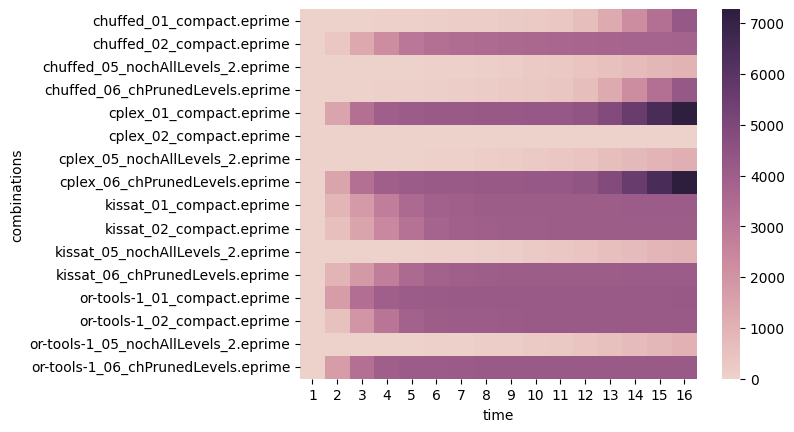

In [180]:
sns.heatmap(mins, xticklabels=np.arange(1,17), yticklabels=combinations, cmap=sns.cubehelix_palette(as_cmap=True))
plt.ylabel("combinations")
plt.xlabel("time");
plt.show()

In [1]:
'''
vb = 97,819.34 pred = 267,300.02 sb = 6,531,714.23
train-val time: 267,300.02

vb = 11,133.69 pred = 415,117.69 sb = 872,317.0
test time: 415,117.69
           319,025
cluster 16:619,114 
'''

'\n97,819.34 267,300.02 6,531,714.23\ntrain-val time: 267,300.02\n\n11,133.69 415,117.69 872,317.0\ntest time: 415,117.69\n'